# NMF による次元削減

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

In [2]:
DATADIR = '../../data/MNIST/raw/'

trainimg_path = DATADIR + 'train-images-idx3-ubyte'
trainlabel_path = DATADIR + 'train-labels-idx1-ubyte'
testimg_path = DATADIR + 't10k-images-idx3-ubyte'
testlabel_path = DATADIR + 't10k-labels-idx1-ubyte'

In [3]:
def load_img(path):
    with open(path, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=16)
    data = data.reshape(-1, 28**2) / 255.0
    return data

def load_label(path):
    with open(path, 'rb') as f:
        label = np.frombuffer(f.read(), np.uint8, offset=8)
    return label

In [4]:
trainimgs = load_img(trainimg_path)
trainlabels = load_label(trainlabel_path)
testimgs = load_img(testimg_path)
testlabels = load_label(testlabel_path)

In [5]:
train = dict()
test = dict()
trainnum = list()
testnum = list()

for i in range(10):
    train[i] = trainimgs[trainlabels == i]
    test[i] = testimgs[testlabels == i]
    trainnum.append(len(train[i]))
    testnum.append(len(test[i]))
pd.DataFrame([trainnum, testnum], columns=range(10), index=['train','test'])

,0,1,2,3,4,5,6,7,8,9
train,5923,6742,5958,6131,5842,5421,5918,6265,5851,5949
test,980,1135,1032,1010,982,892,958,1028,974,1009


### まとめて辞書を作る

In [6]:
eachnum = 100
X = np.empty((10*eachnum, 28**2))

for i, (t, tn) in enumerate(zip(train.values(), trainnum)):
    X[eachnum*i:eachnum*(i+1)] = t[np.random.choice(tn, eachnum)]

X.shape

(1000, 784)

In [7]:
%%time
from sklearn.decomposition import NMF

n_components = 20

model = NMF(n_components=n_components)
model.fit(X)

Wall time: 1.83 s


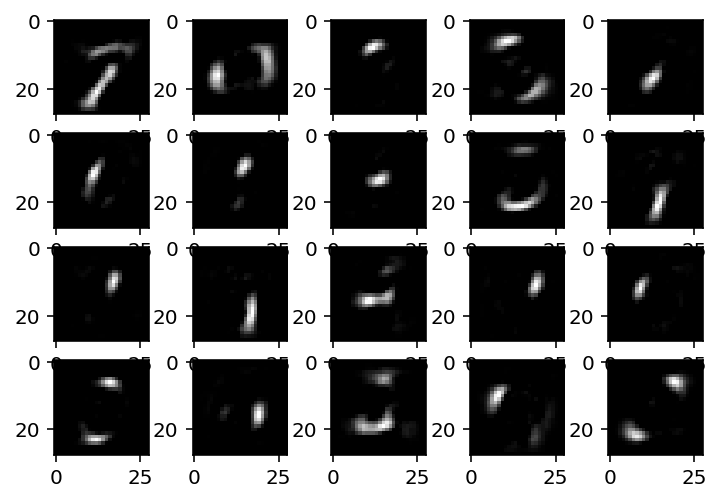

In [8]:
H = model.components_

for i, base in enumerate(H, start=1):
    img = base.reshape(28, 28)
    plt.subplot(4, 5, i)
    plt.imshow(img, cmap='gray')
plt.show()

In [9]:
eachnum = 3
testX = np.empty((10*eachnum, 28**2))

for i, (t, tn) in enumerate(zip(test.values(), testnum)):
    testX[eachnum*i:eachnum*(i+1)] = t[np.random.choice(tn, eachnum)]
testX.shape

(30, 784)

In [10]:
%%time
testW = model.transform(testX) 

Wall time: 3.99 ms


In [11]:
reimgs = testW @ H
reimgs.shape

(30, 784)

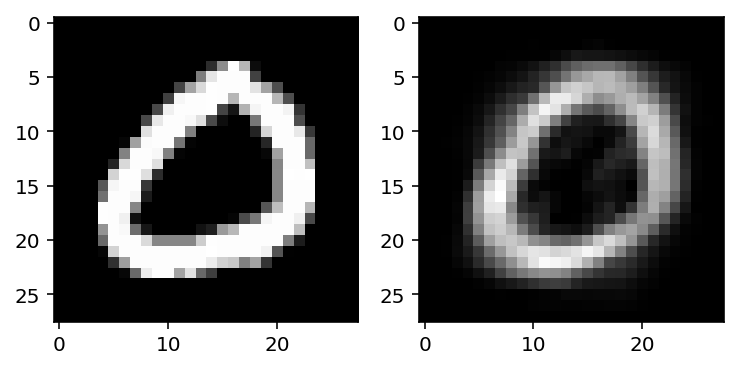

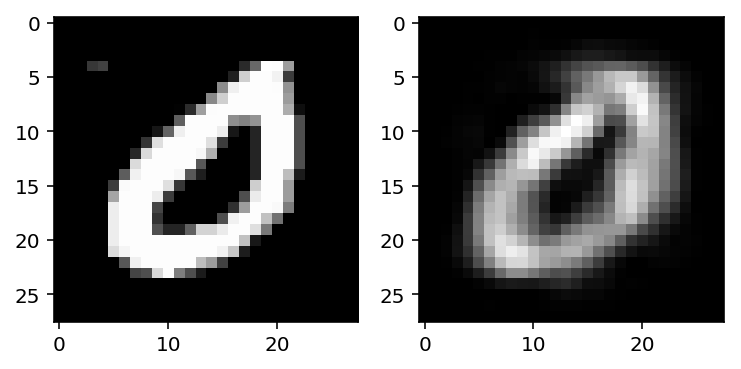

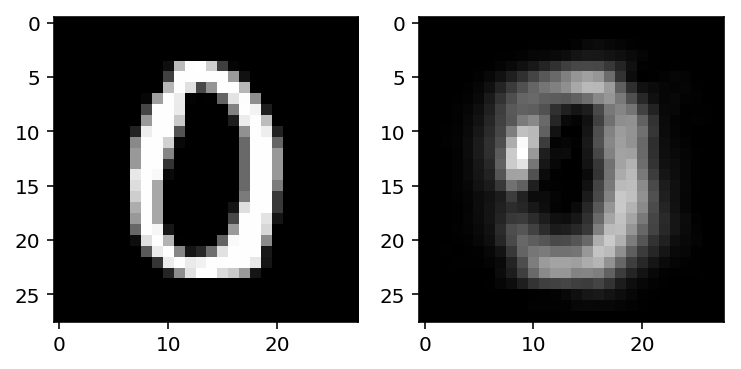

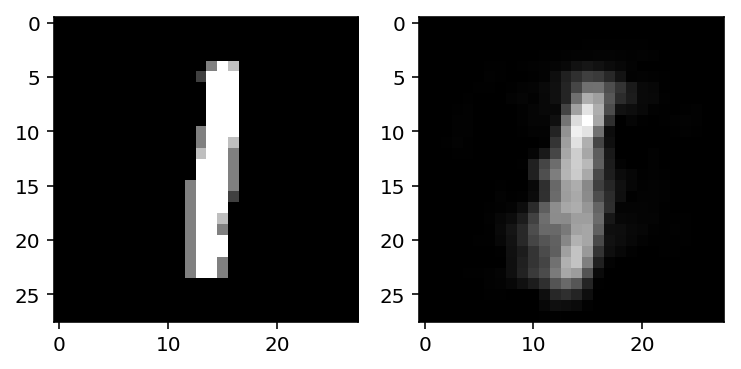

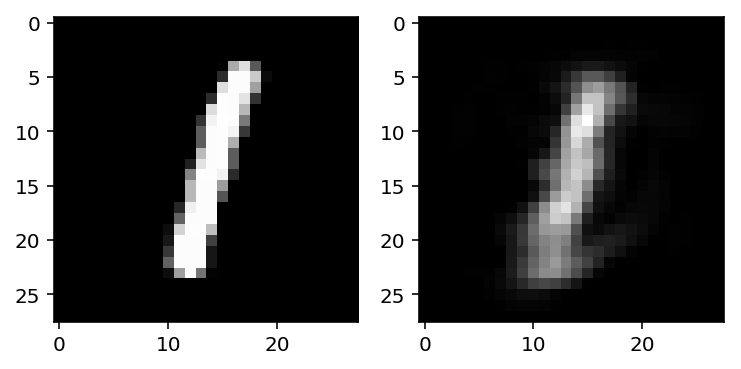

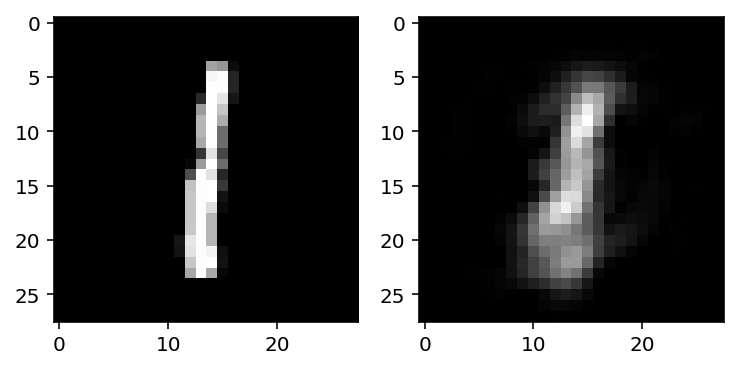

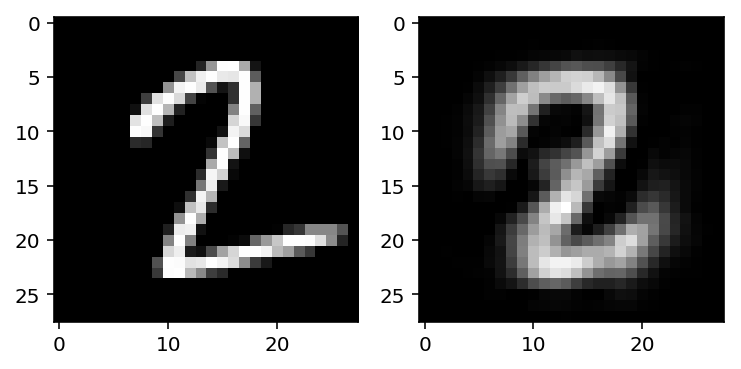

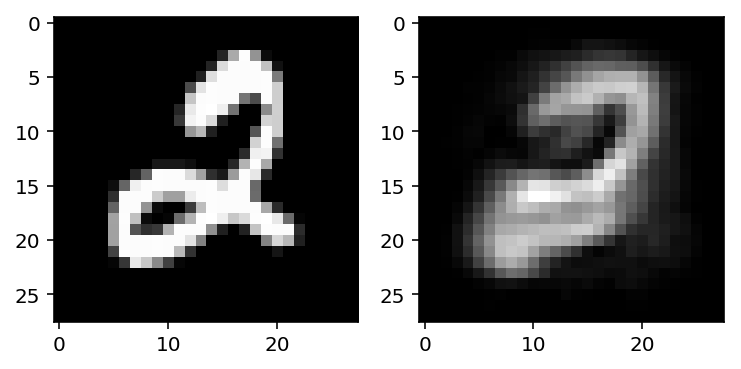

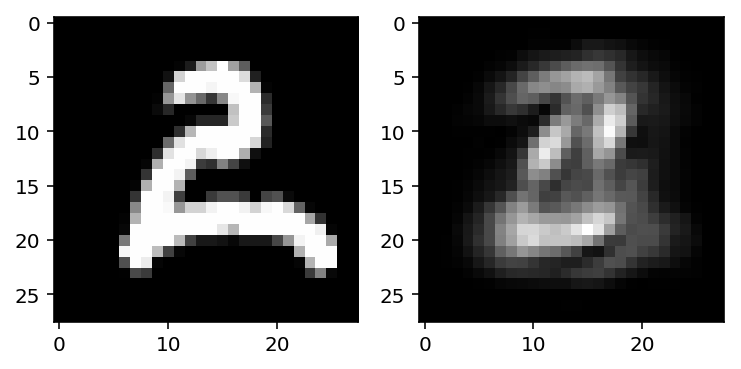

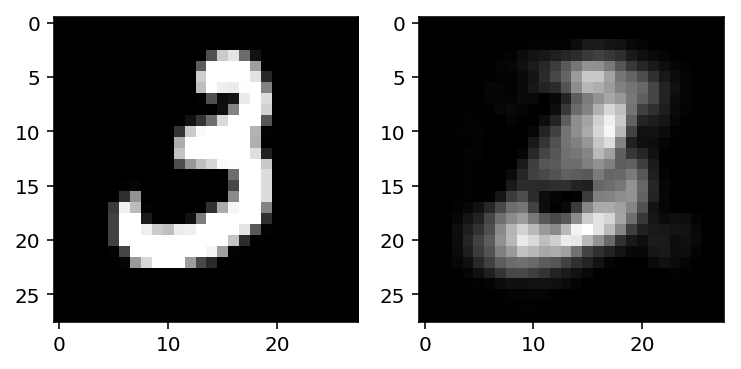

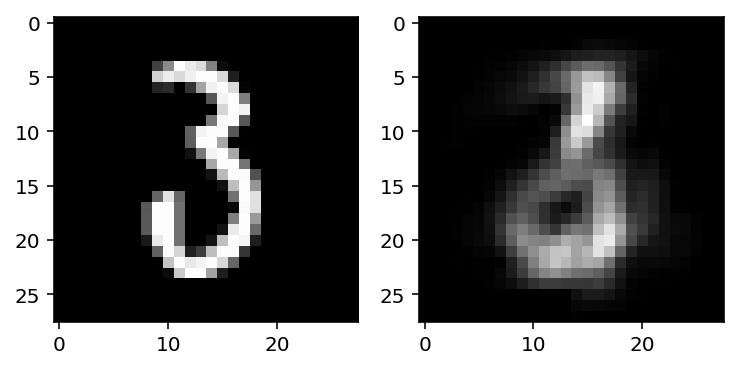

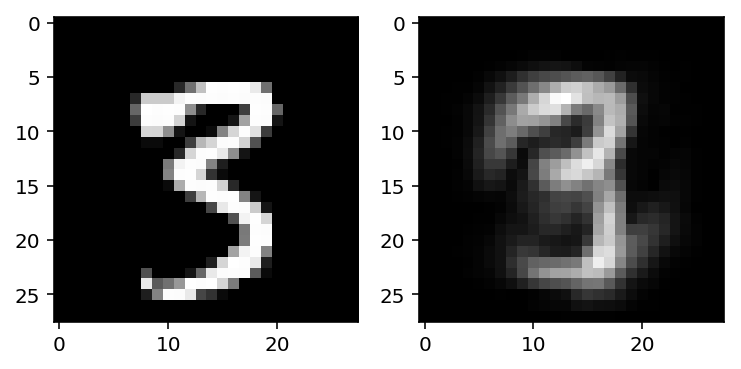

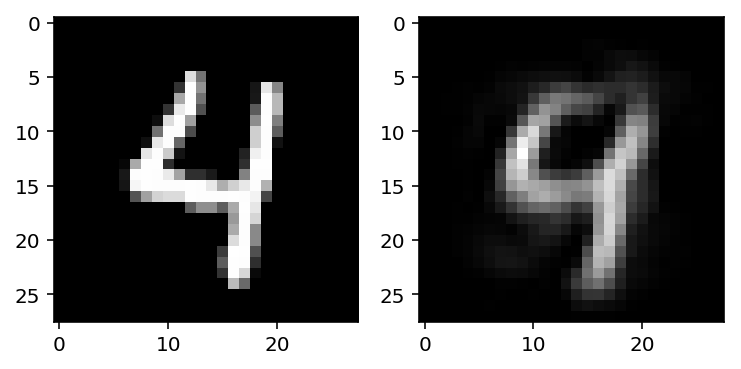

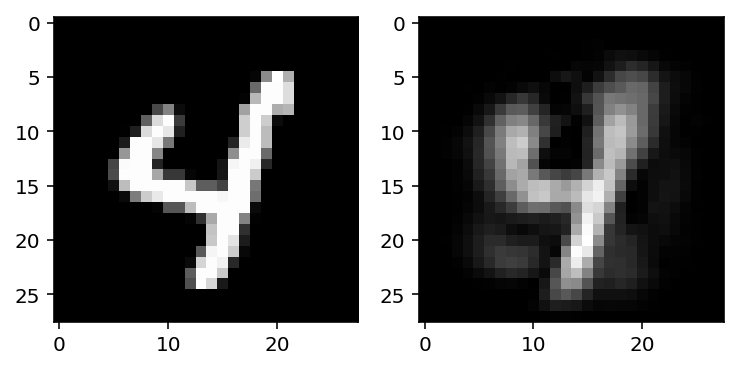

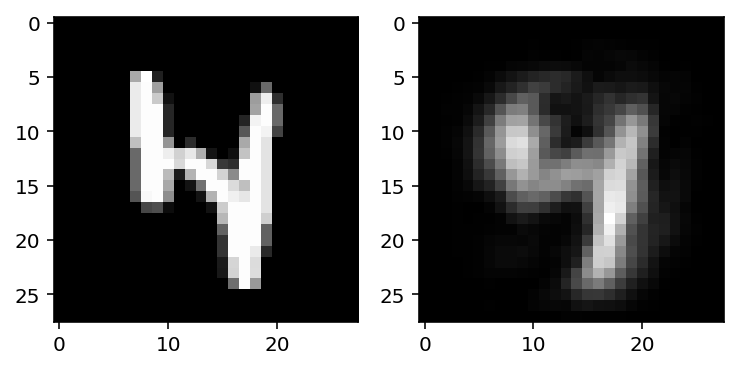

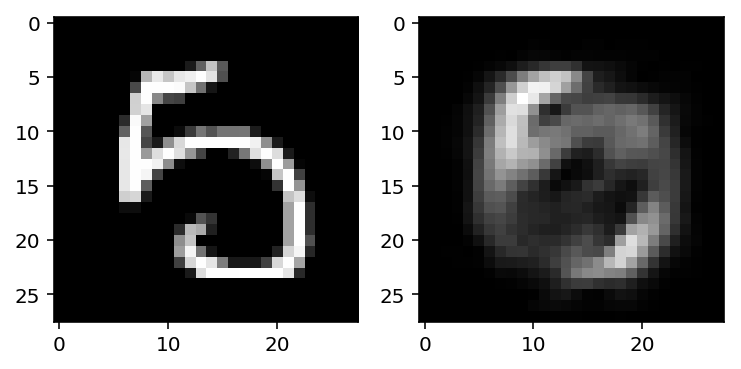

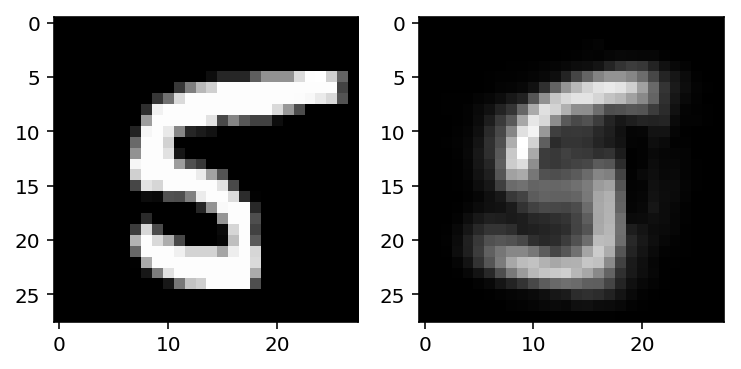

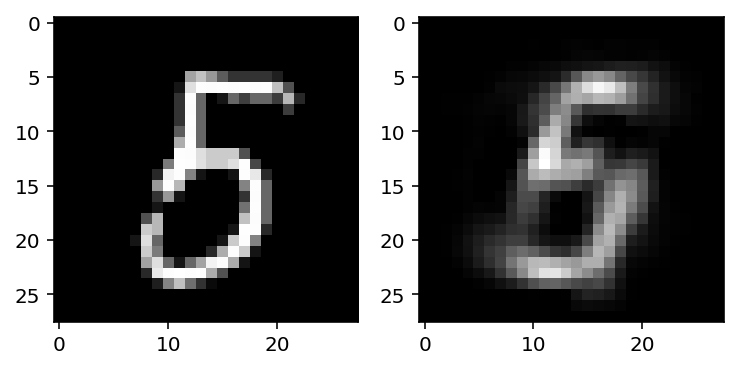

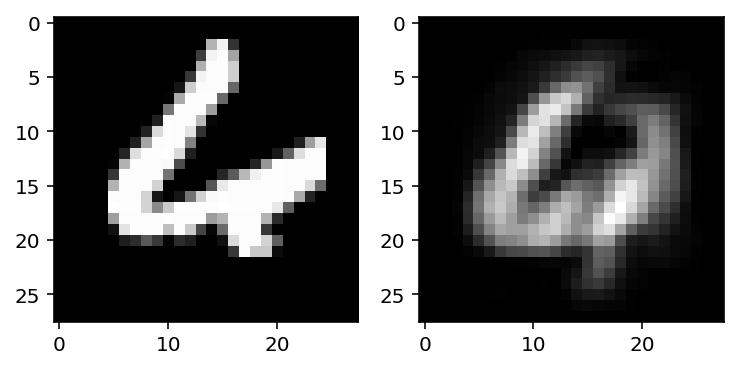

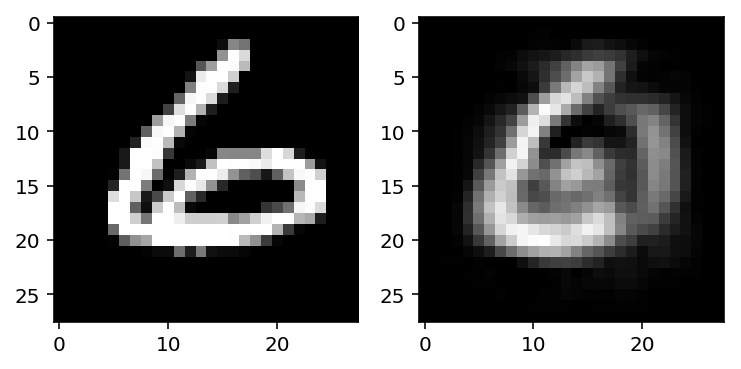

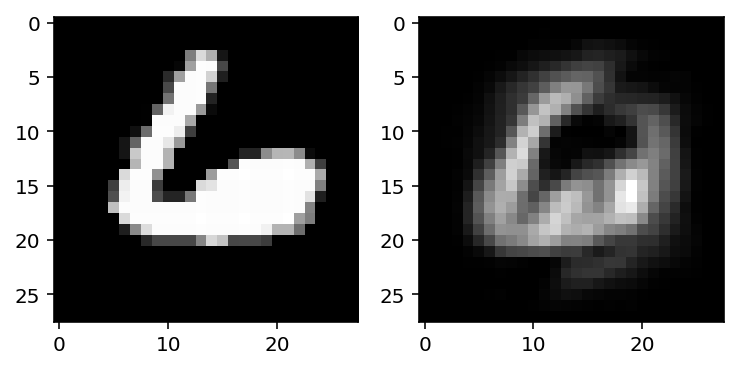

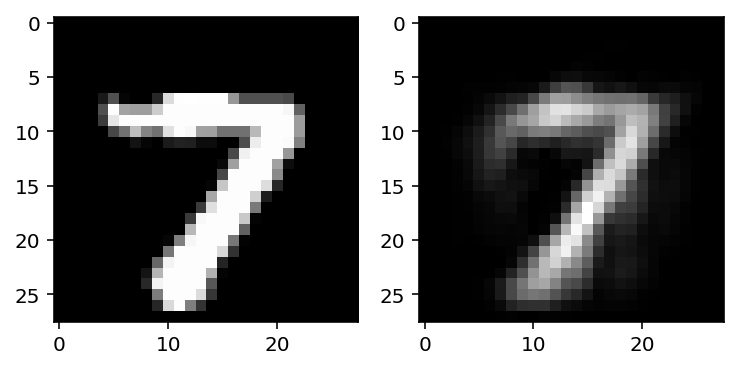

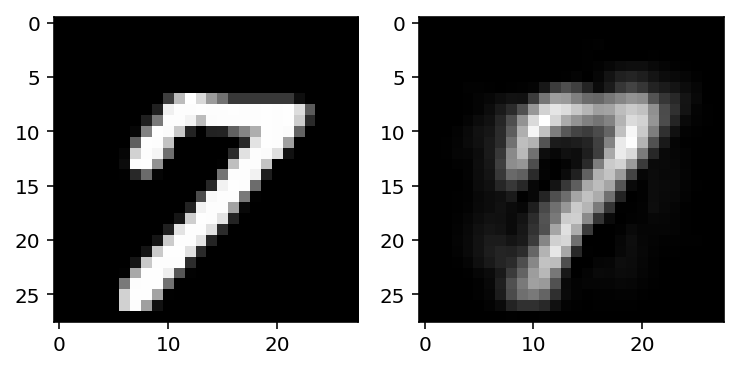

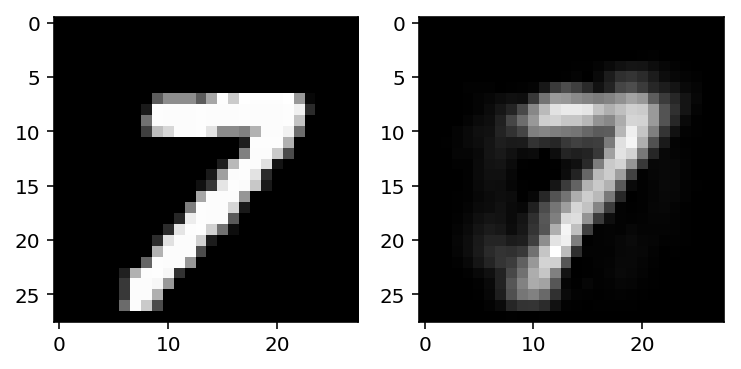

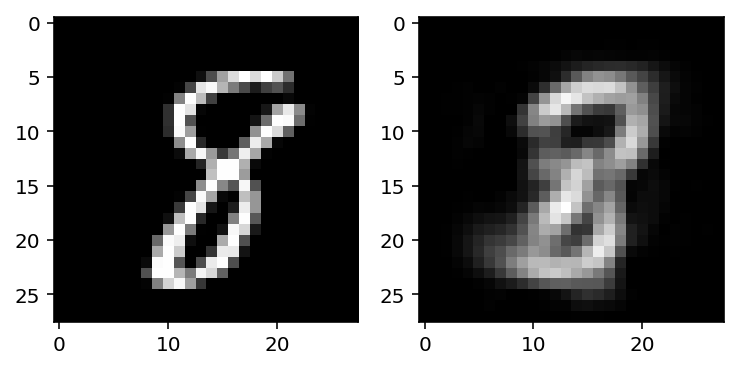

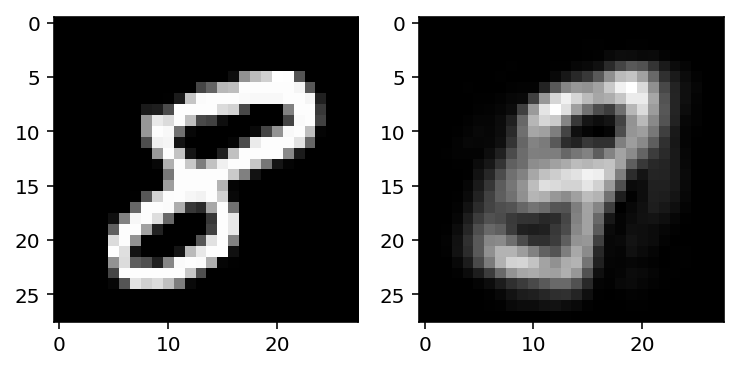

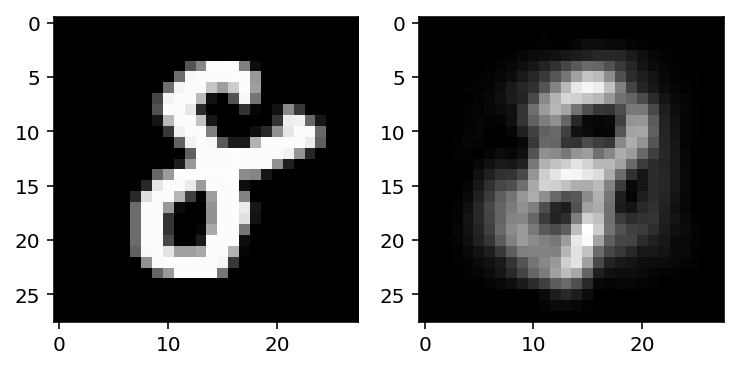

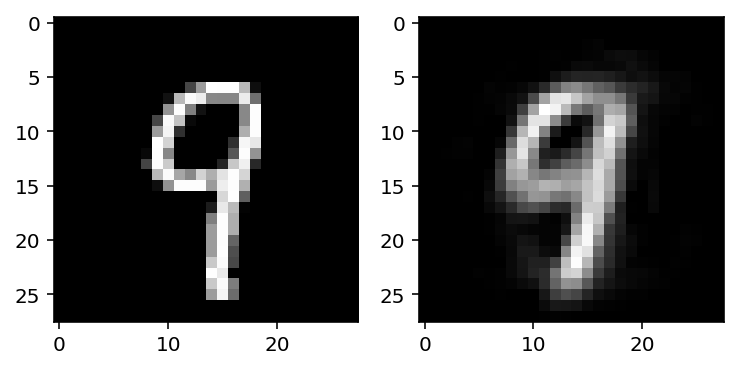

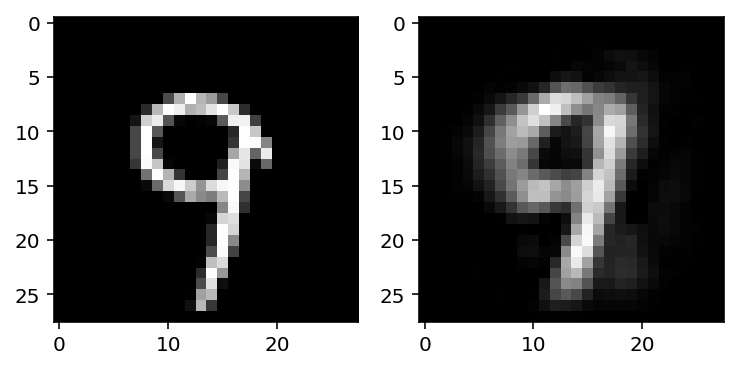

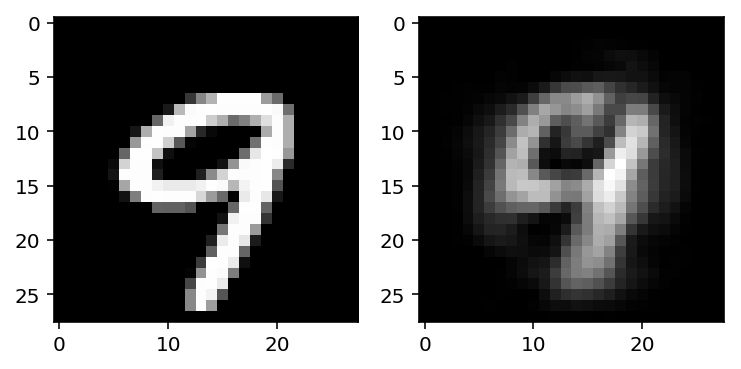

In [12]:
for img, reimg in zip(testX, reimgs):
    img = img.reshape(28, 28)
    reimg = reimg.reshape(28, 28)
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap='gray')
    plt.subplot(1, 2, 2)
    plt.imshow(reimg, cmap='gray')
    plt.show()

### 数字毎に辞書を作る

In [6]:
%%time
from sklearn.decomposition import NMF

models = dict()
n_components = 10
eachnum = 1000

for (i, t), tn in zip(train.items(), trainnum):
    X = t[np.random.choice(tn, eachnum)]
    model = NMF(n_components=n_components)
    model.fit(X)
    models[i] = model

Wall time: 6.4 s


0


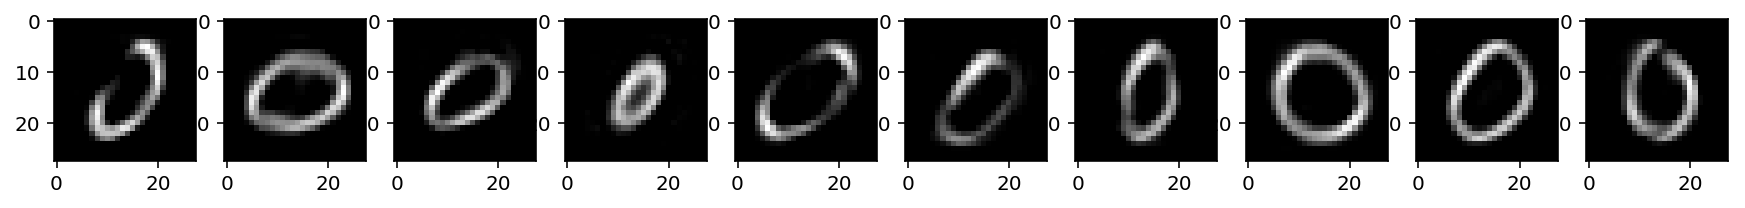

1


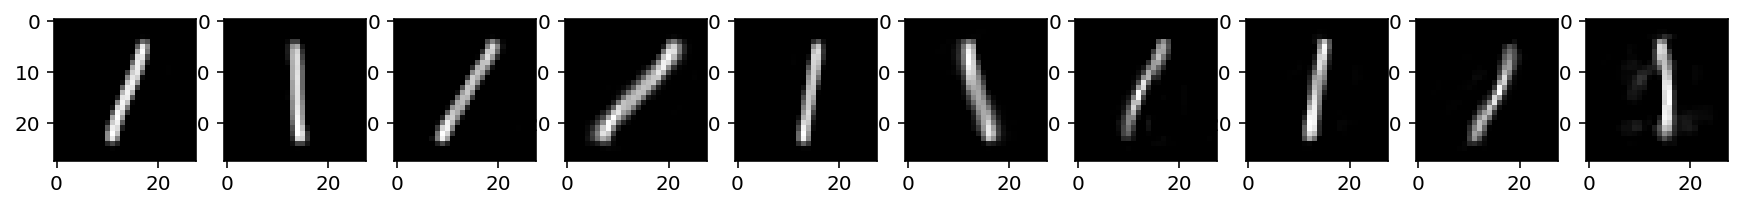

2


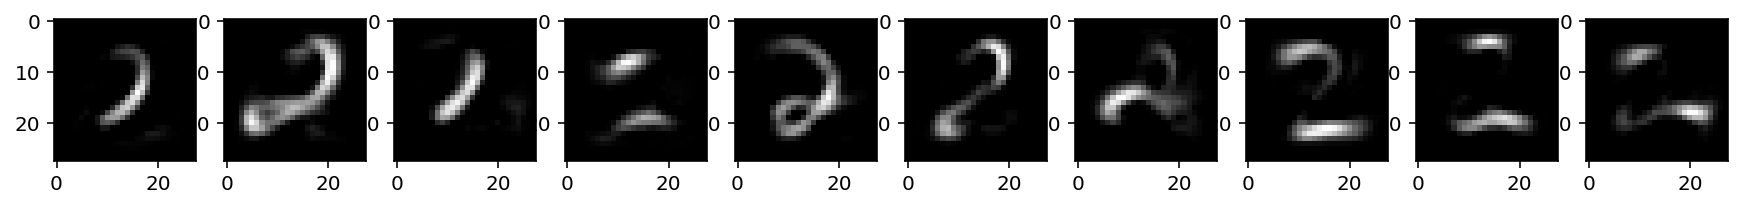

3


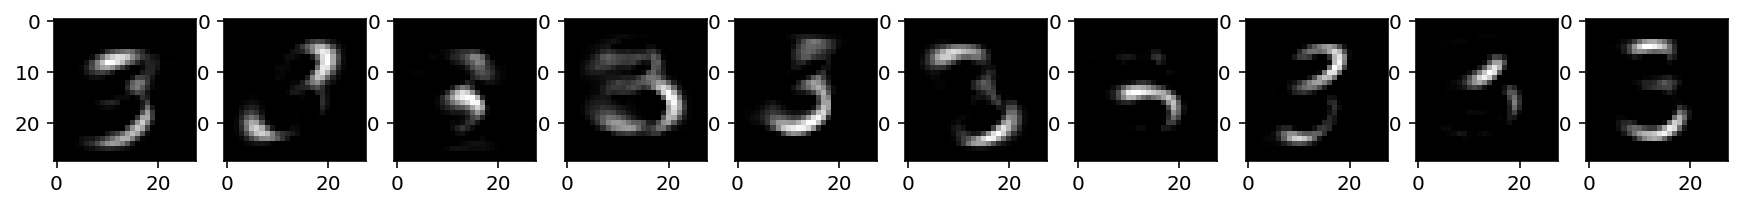

4


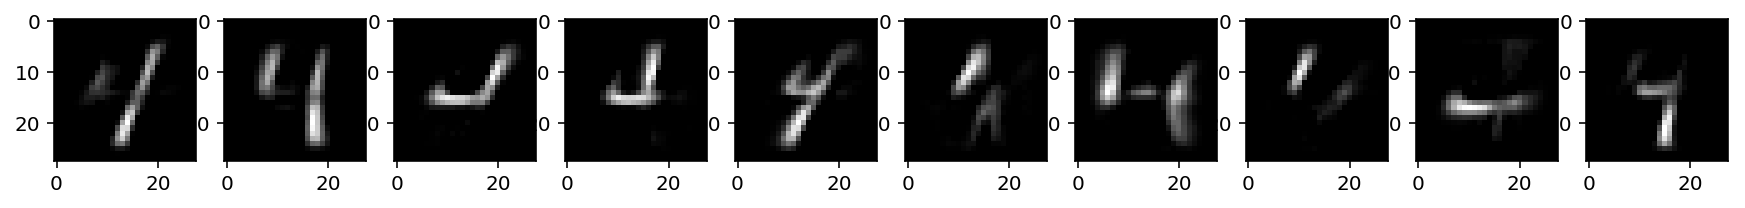

5


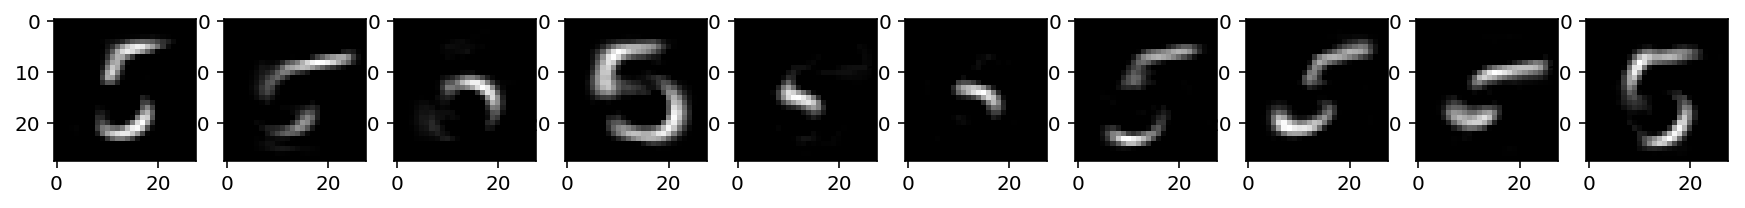

6


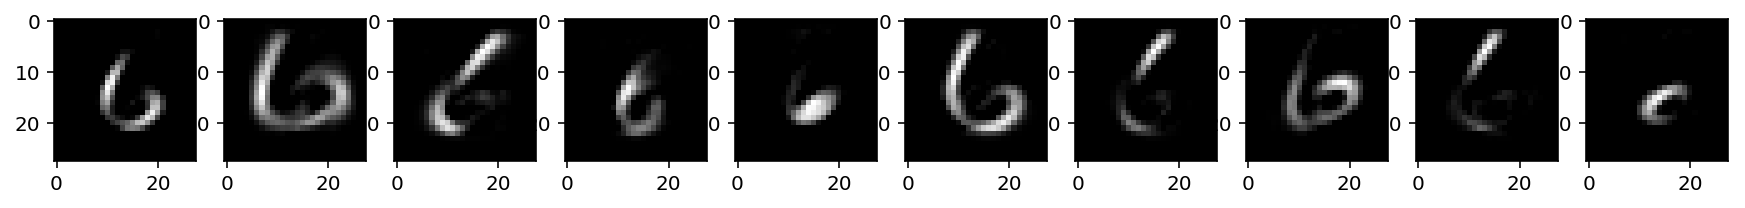

7


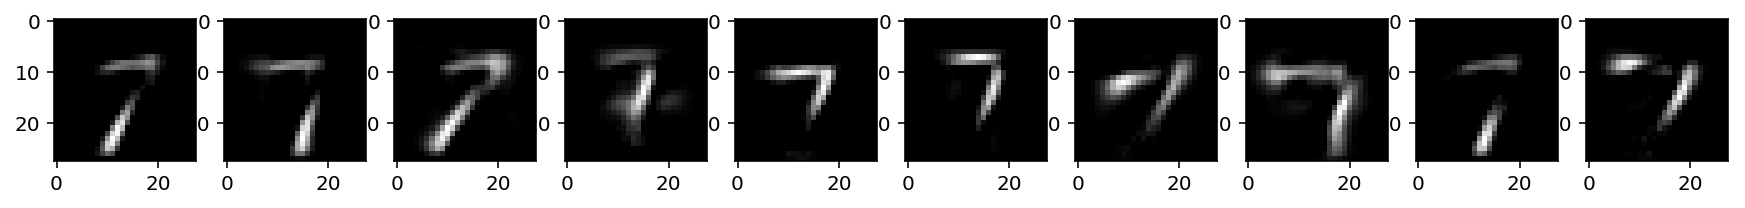

8


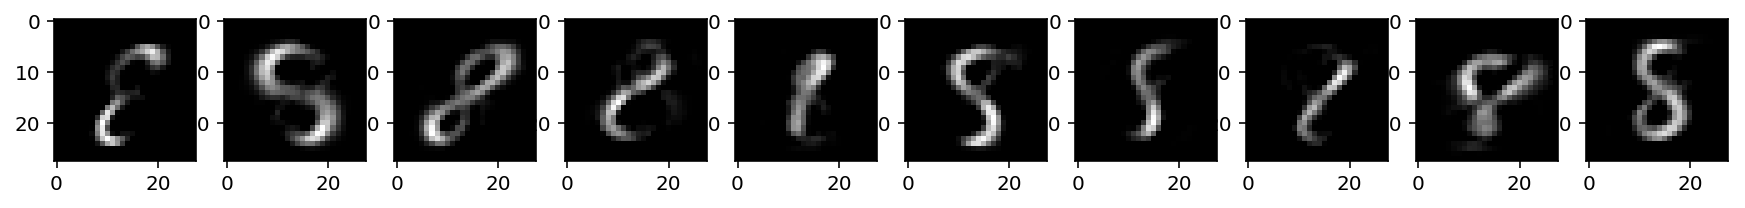

9


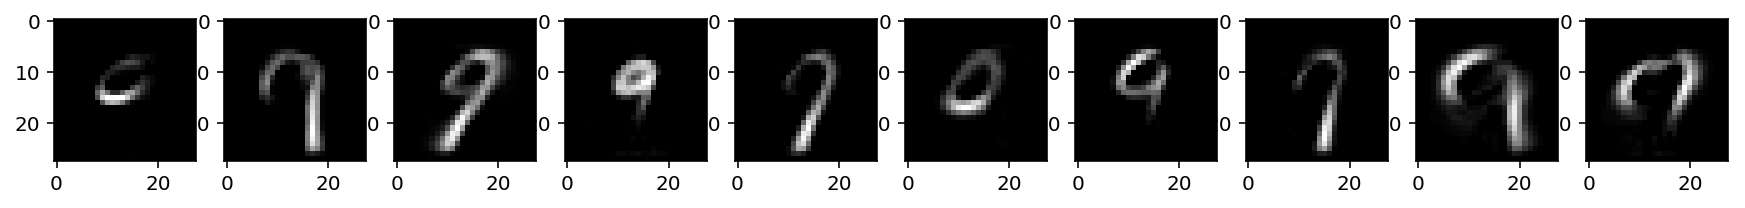

In [8]:
for i, model in models.items():
    H = model.components_
    print(i)
    plt.figure(figsize=(15, 3))
    for i, base in enumerate(H, start=1):
        img = base.reshape(28, 28)
        plt.subplot(1, 10, i)
        plt.imshow(img, cmap='gray')
    plt.show()

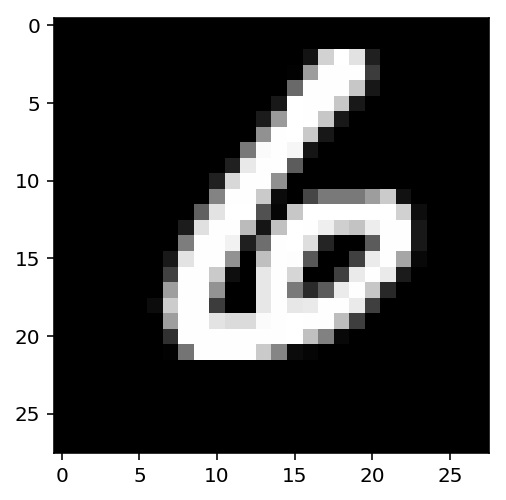

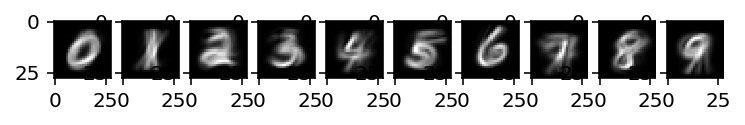

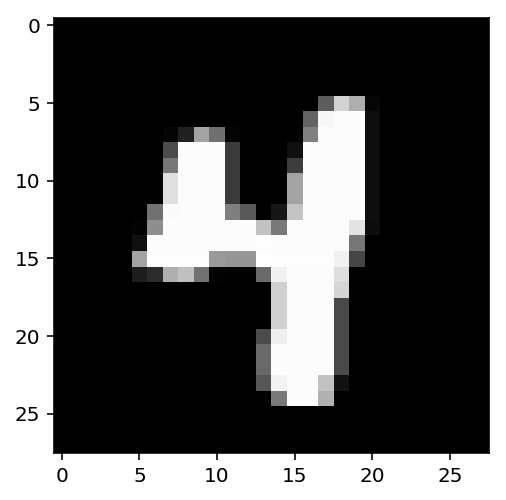

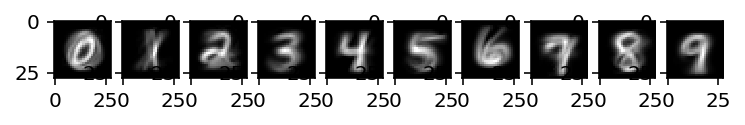

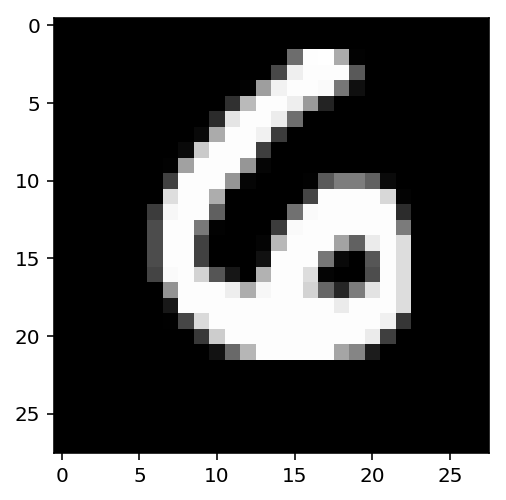

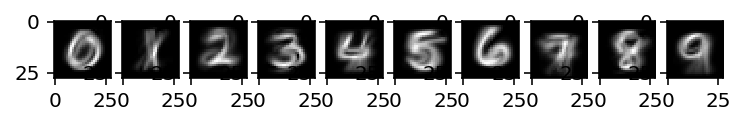

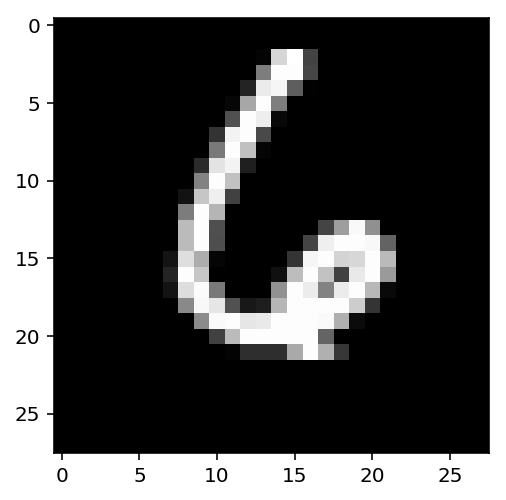

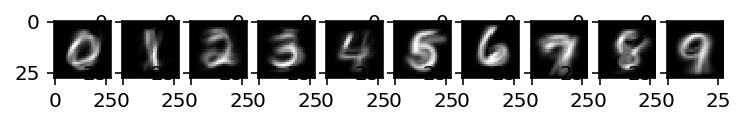

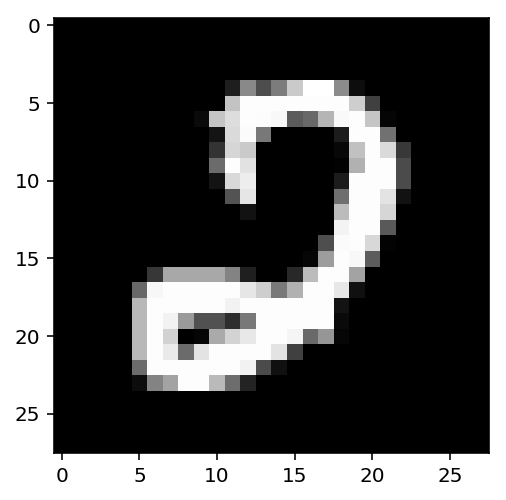

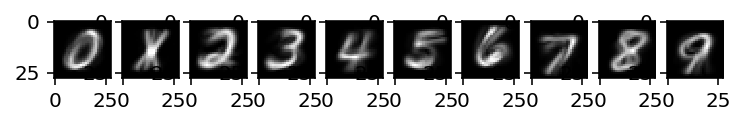

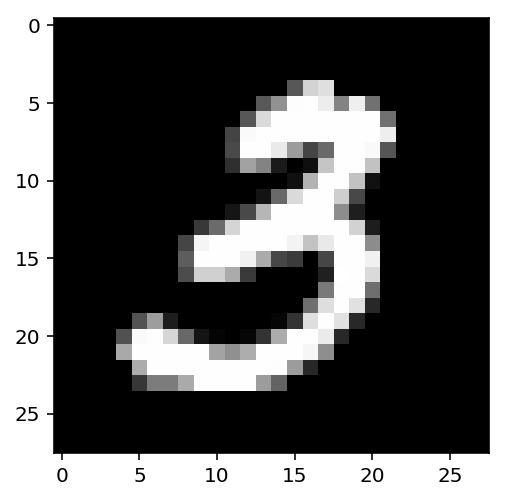

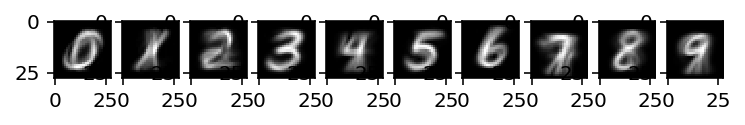

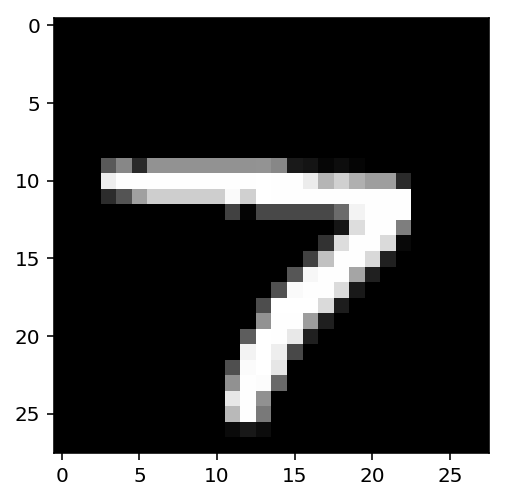

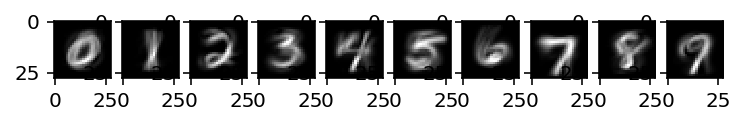

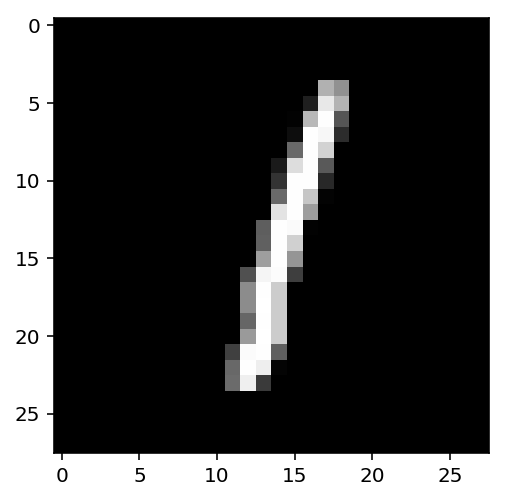

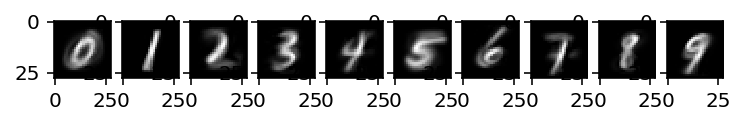

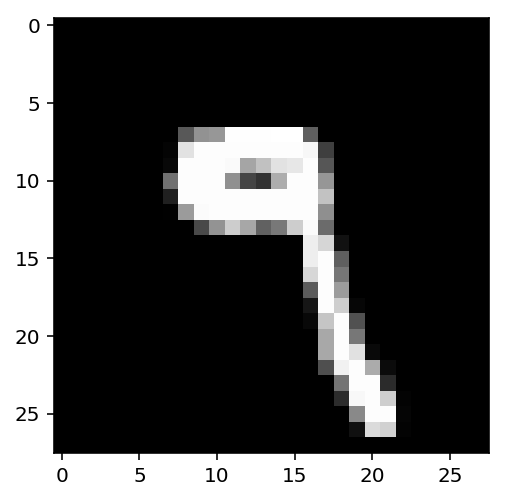

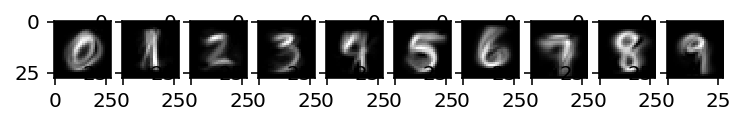

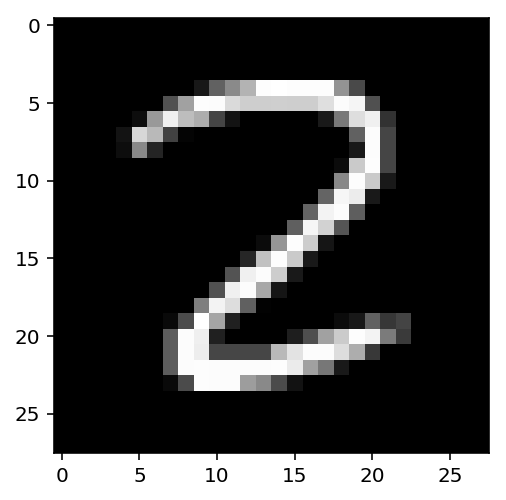

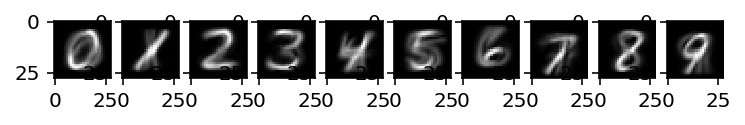

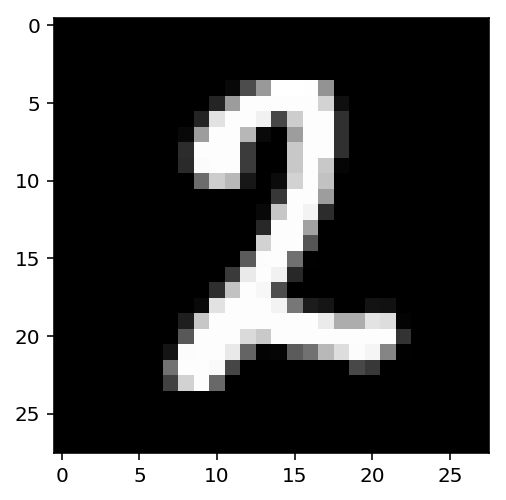

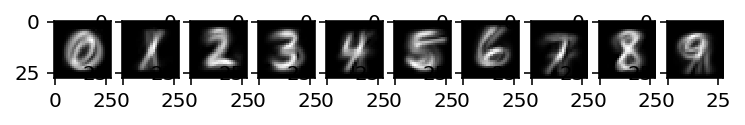

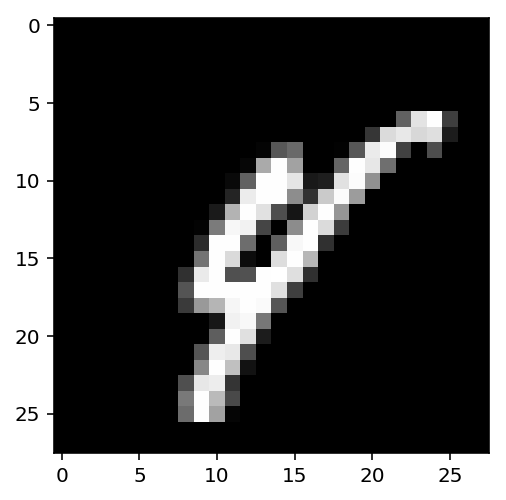

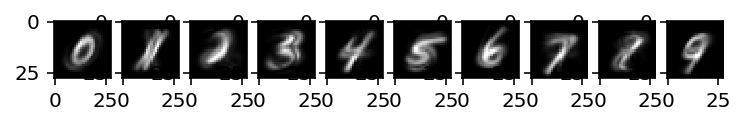

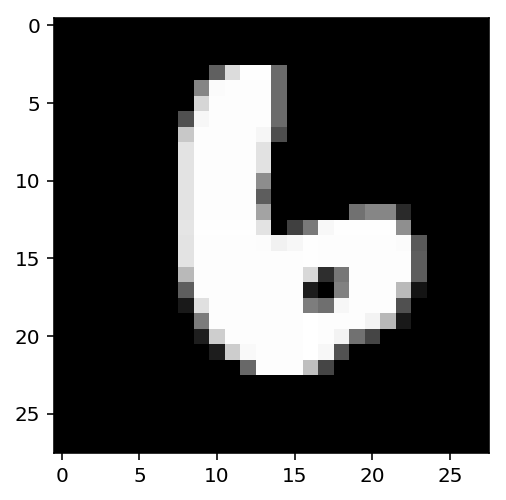

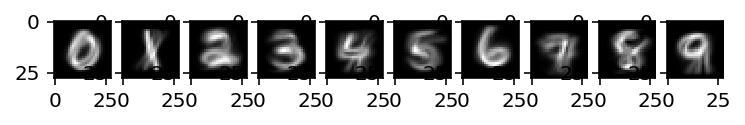

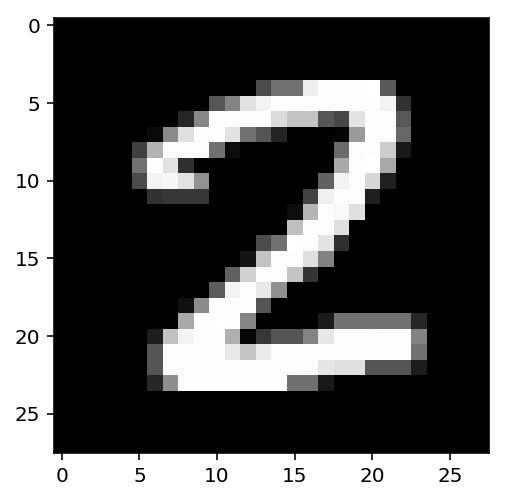

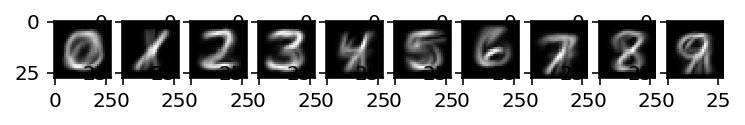

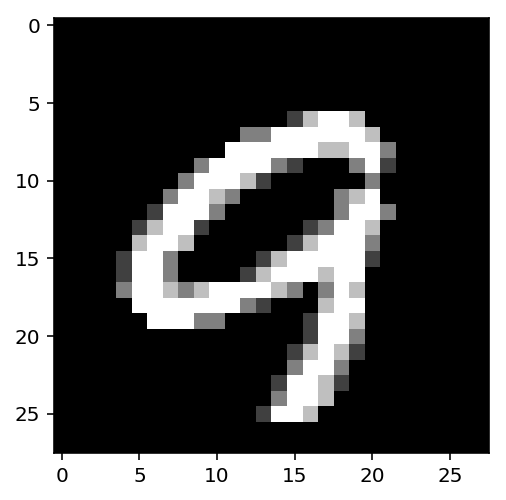

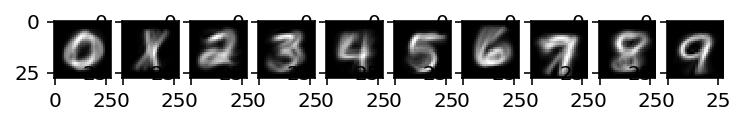

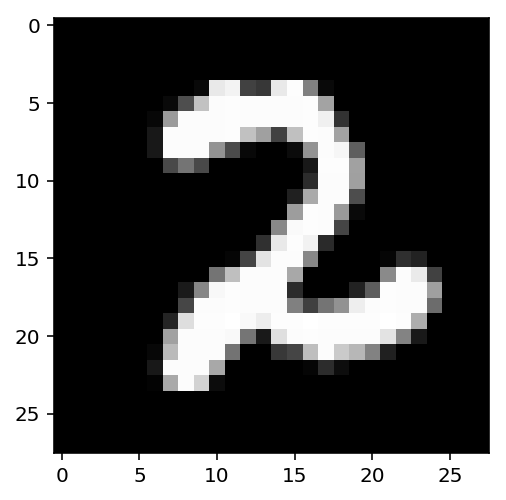

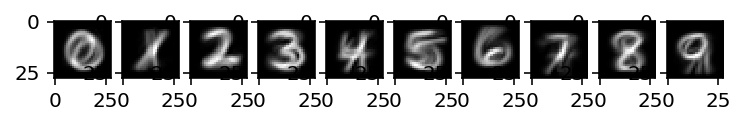

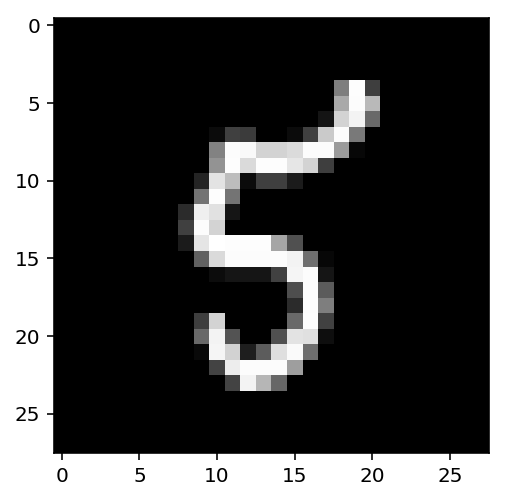

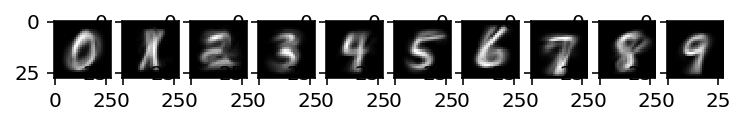

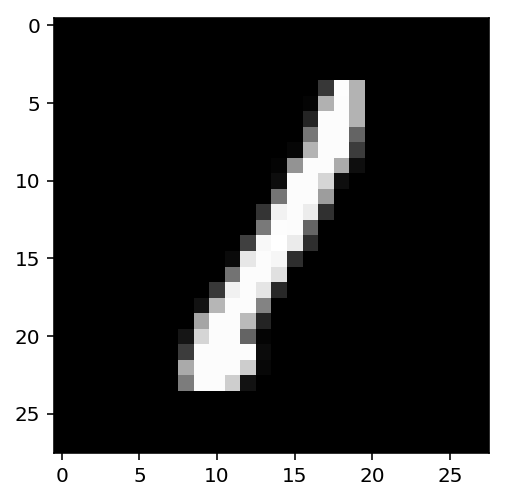

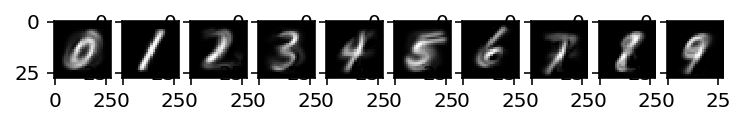

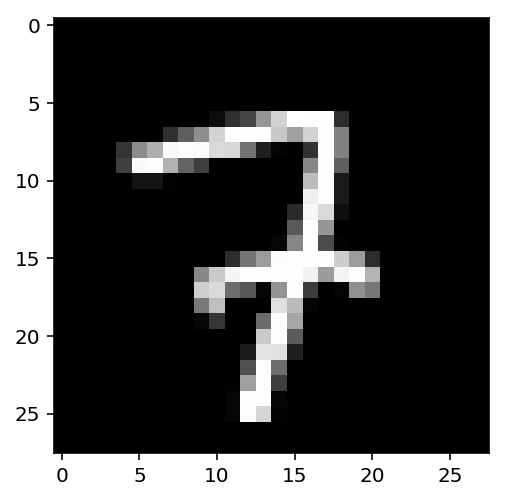

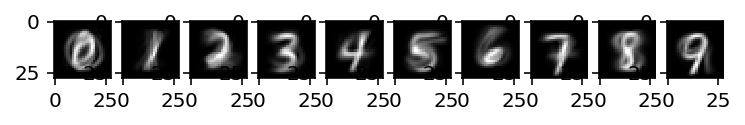

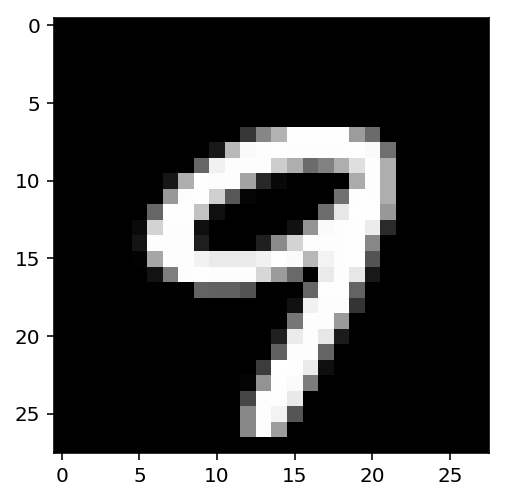

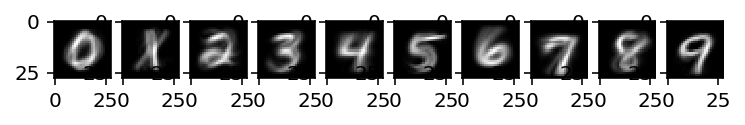

Wall time: 20.1 s


In [9]:
%%time
testX = testimgs[np.random.choice(10000, 20)]
for img in testX:
    plt.imshow(img.reshape(28, 28), cmap='gray')
    plt.show()
    for i, model in models.items():
        testW = model.transform([img])
        reimg = testW @ model.components_
        
        plt.subplot(1, 10, i+1)
        plt.imshow(reimg.reshape(28, 28), cmap='gray')
    plt.show()

### 再構成画像と元の画像が最も近いものを正解にする

In [10]:
%%time

diffs = list()

for i, model in models.items():
    testW = model.transform(testimgs)
    reimgs = testW @ model.components_
    diff = np.sum((testimgs - reimgs) ** 2, axis=1)
    diffs.append(diff)

nearests = np.argmin(diffs, axis=0)
correct = np.sum(testlabels == nearests)

print(f'testnum: {len(testlabels)}')
print(f'correct :{correct}')
print(f'corrrectrate: {correct / len(testlabels)} %')

testnum: 10000
correct :9293
corrrectrate: 0.9293 %
Wall time: 3.74 s
